In [47]:
println("Hello super people!")

Hello super people!


In [48]:
using Random, Plots, Statistics, Combinatorics, LaTeXStrings, CSV, DataFrames, StatsBase


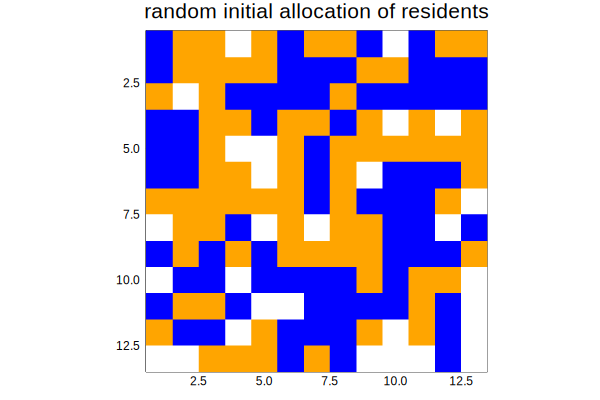

In [49]:

#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = GRID_SIZE^2

THRESHOLD_SAME = 4
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

PP = 5

MM = 10#number of simulations
TT = 25#number of time points in simulation


yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
empty_count = CELL_COUNT - yellow_count - blue_count

#the total number of possible configurations
CELLS_SPACE_SIZE = multinomial(BigInt(yellow_count),BigInt(blue_count),BigInt(empty_count))
#println(CELLS_SPACE_SIZE)

#boltzmann constant
k_b = 1.380649*10^-23


empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

start_grid = shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h = heatmap(start_grid,title="random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


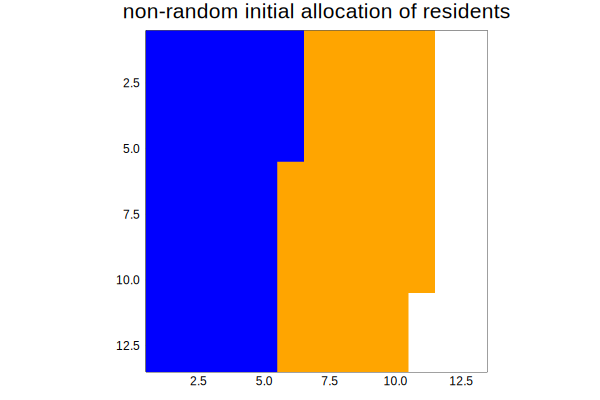

In [50]:
savefig(h,"figs/randomAllocationInit.png")

yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

set_grid = empty_grid#shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h2 = heatmap(set_grid,title="non-random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

In [51]:
savefig(h2,"figs/setAllocation.png")

#macrostate function mapping (eg, what is the total satisfaction of the residents overall the cells, total sum from zero to max)
#function overall_satisfaction(start_grid)

function grid_satisfaction(grid)
    cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            
            t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_satisfaction,tmpBinary)
        end
    end
    return sum(cell_satisfaction)
end

function thresholdFN(cellSurroundArray,cellType,row,col)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end
function cell_surround_arrayTMP(grid,row,col)
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end

R_MAX = grid_satisfaction(set_grid)
println("set grid satisfaction value MAX=",R_MAX)
R_START = grid_satisfaction(start_grid)
println("set grid satisfaction value START=",R_START)


set grid satisfaction value MAX=140
set grid satisfaction value START=64


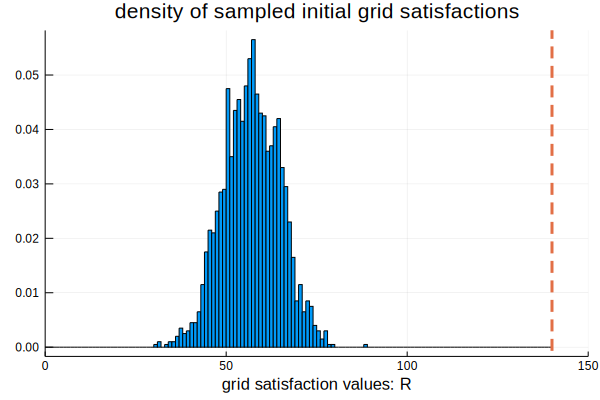

In [52]:
#sample the random intializations and investigate 
function make_random_grid()
    empty_grid = zeros(GRID_SIZE,GRID_SIZE)
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    random_grid = shuffle(empty_grid)
    return random_grid
end
numberOfRandomSamples = 2000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]
normedRandomSatisfactions = randomSatisfactions ./ sum(randomSatisfactions)
pltHist = histogram(randomSatisfactions,bins=0:1:R_MAX,normalize=:probability,xlim=(0,R_MAX+10),title="density of sampled initial grid satisfactions",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

In [53]:
savefig(pltHist,"figs/histogramOfSampledInitSatisfactions.png")

#llok at not the grid level satisfaction but the single cell level satisfaction
function cell_surround_array(grid,row,col)
    #if((row==1 && col==1))#top left corner
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end
  
    return cell_surrounding
end

function is_cell_satisfied(grid,row,col)
    cellSurroundArray = cell_surround_array(grid,row,col)
    #println(cellSurroundArray)
    cellType = grid[row,col]
    #println(cellType)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = is_cell_satisfied(start_grid,8,7)
#println(cell_satisfied)
 


is_cell_satisfied (generic function with 1 method)

In [54]:
#testing for if a cell would be satisfied if it were placed there
function would_cell_be_satisfied(grid,row,col,cellType)
    cellSurroundArray = cell_surround_array(grid,row,col)    
    #println(cellSurroundArray)
    homogeneity = length(findall(cellType .== cellSurroundArray))    
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = would_cell_be_satisfied(start_grid,7,9,start_grid[2,2])
#println(cell_satisfied)
 

would_cell_be_satisfied (generic function with 1 method)

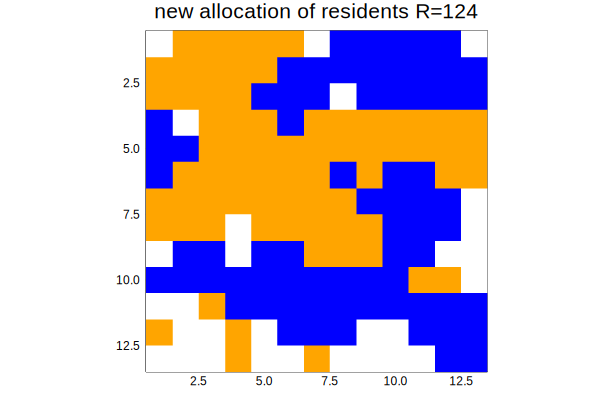

In [55]:
#get non-empty cell set
#Search for an unsatisfied iteratively in all the cells through a shuffled list
#find all empty cells
#shuffle the list of the empty cells
#see if the cell would_cell_be_satisfied in any of the cells in sequence
#no, move on to the next cell
#if yes, change the original cell position to empty and make the new cell the cell type
#loop till all non-empty cells are tested

function move_cells_for_satisfaction(grid)
    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    #R_START = grid_satisfaction(grid)

    #remove (skip) the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end   
            #=if(moved == false)
                println("cell at i=$(nzc[1]) and j=$(nzc[2]) did not move")
            end=#
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
#println(satisfiedOneGrid)
h3 = heatmap(newGrid,title="new allocation of residents R=$(satisfiedOneGrid)",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


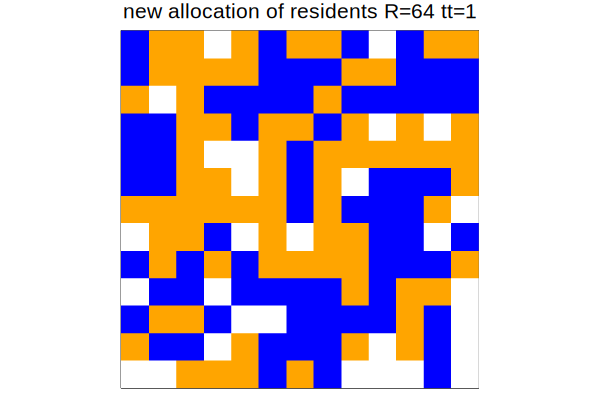

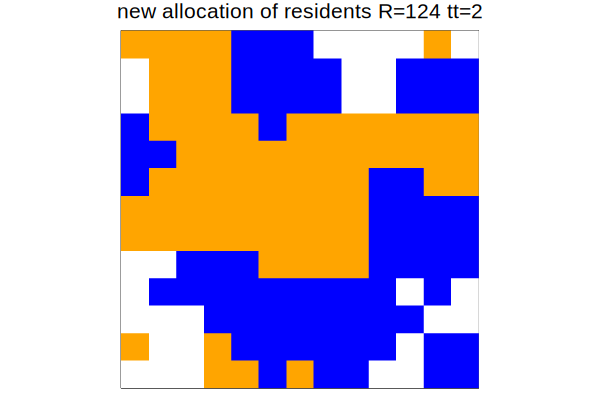

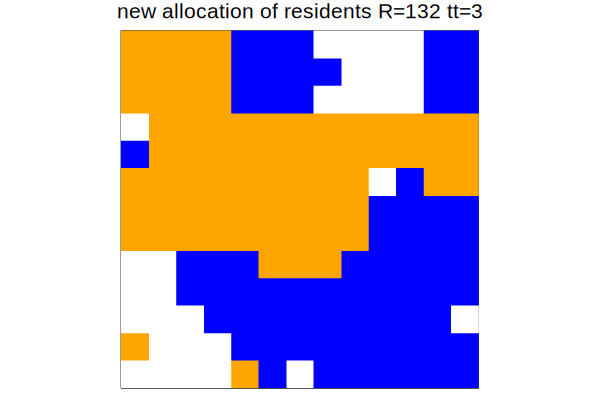

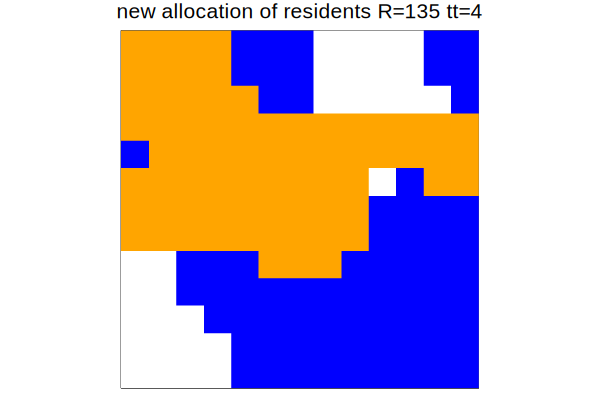

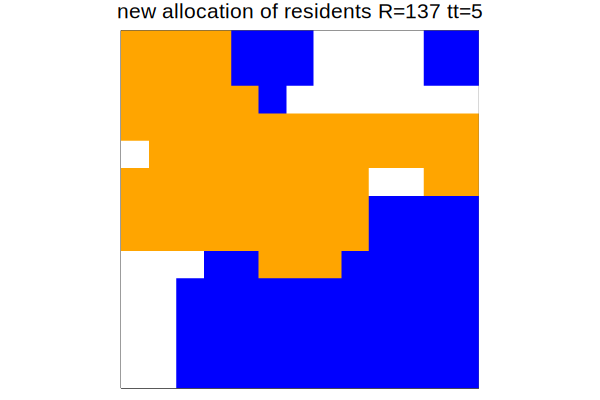

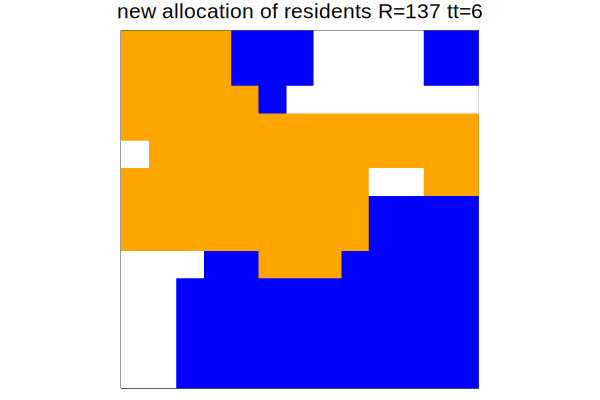

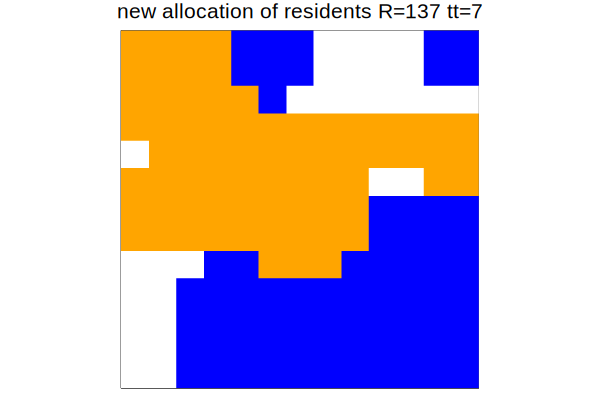

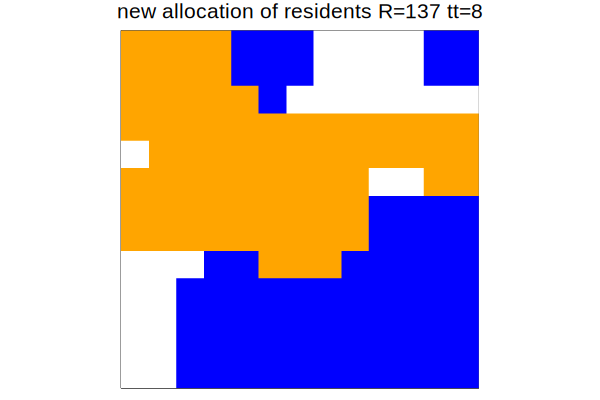

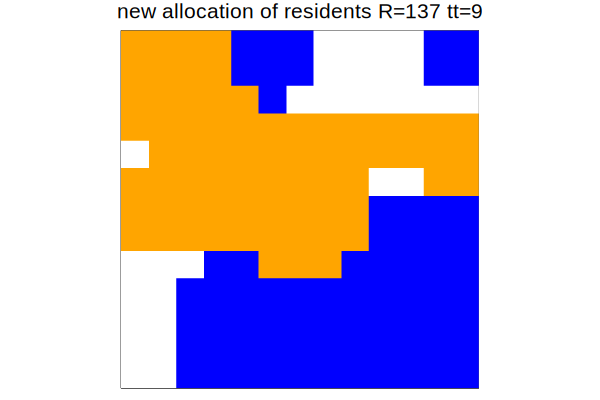

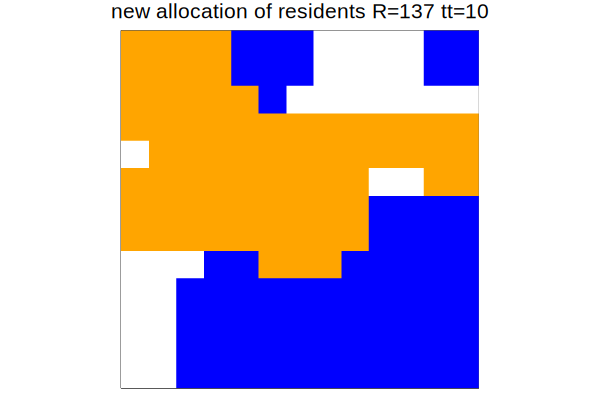

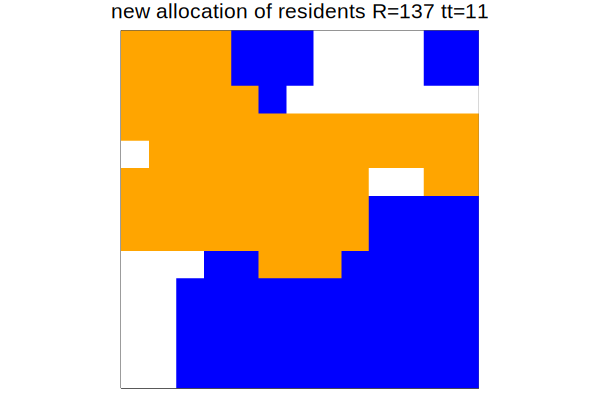

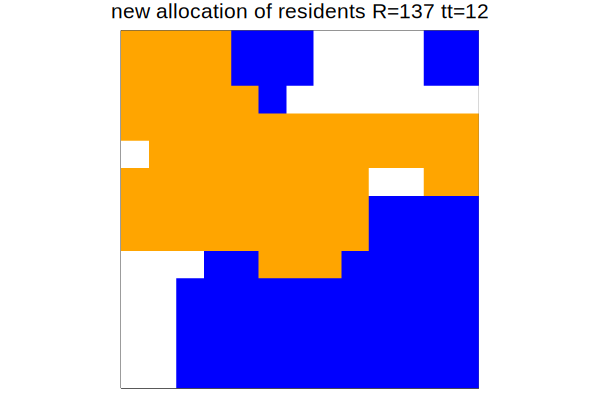

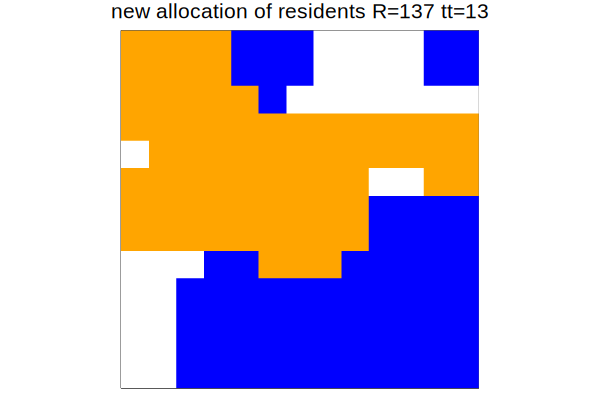

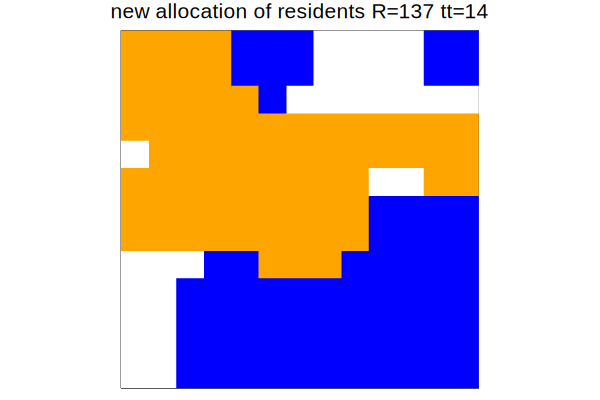

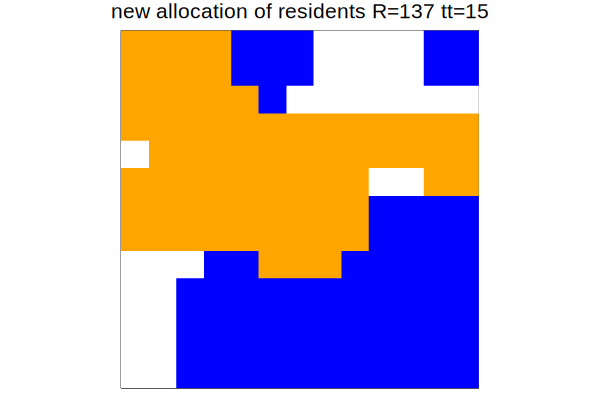

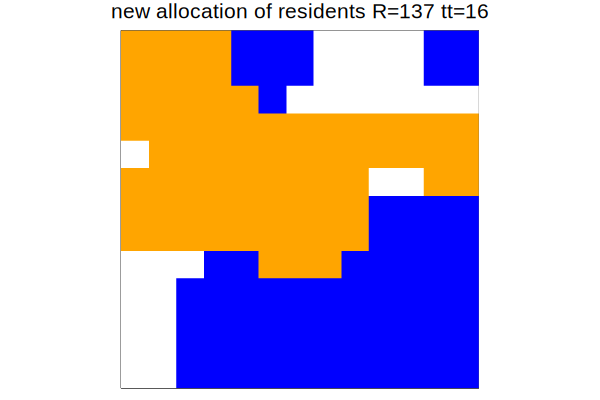

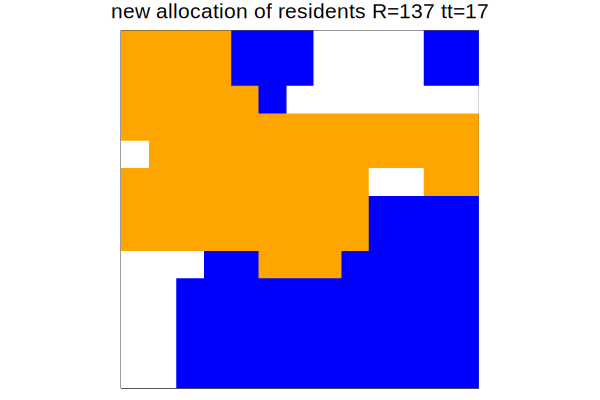

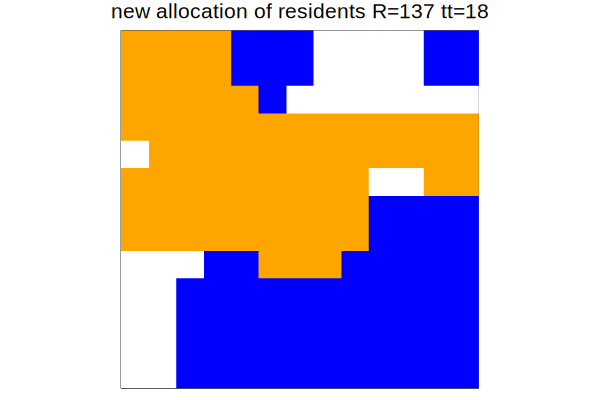

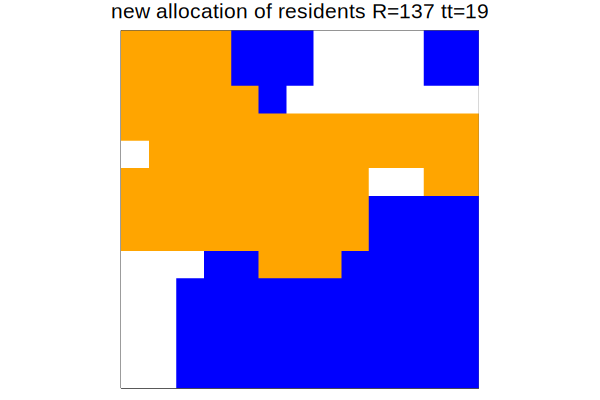

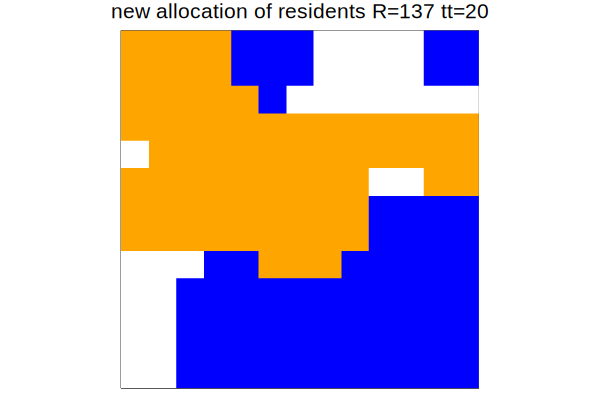

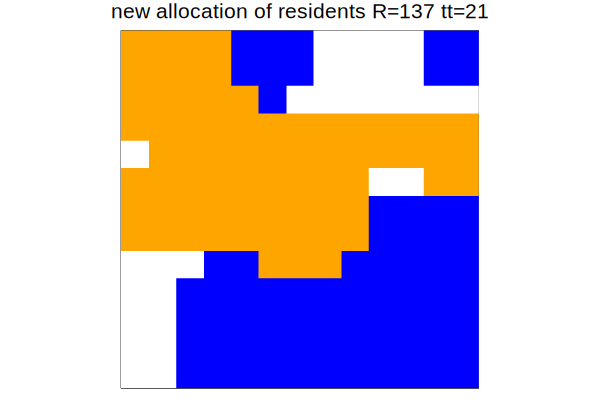

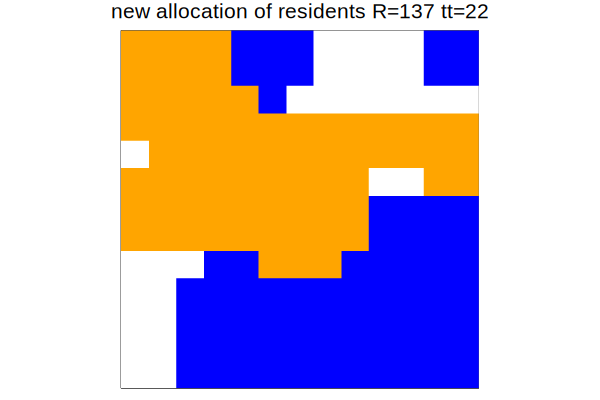

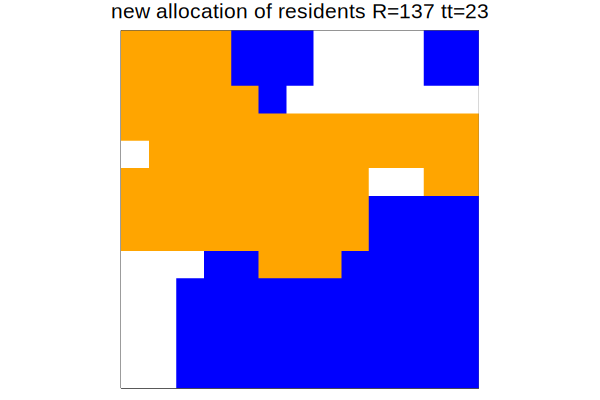

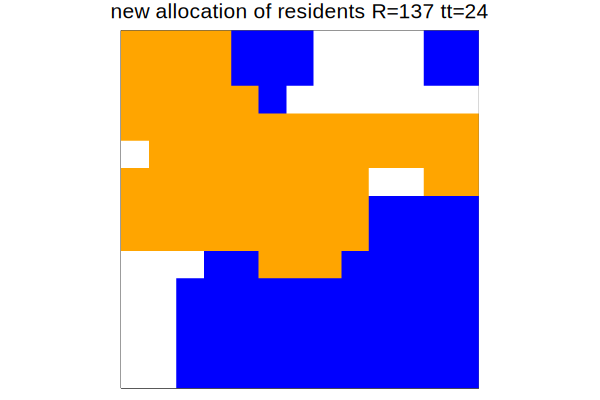

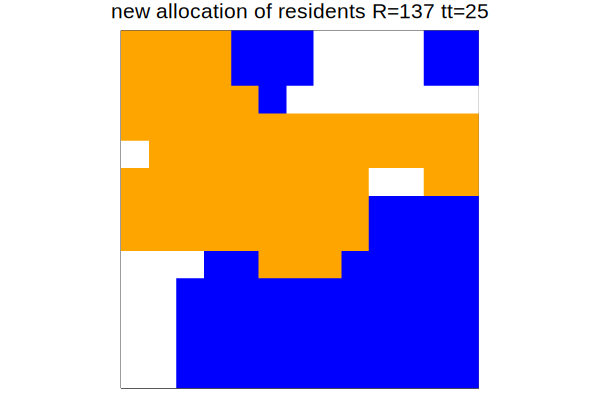

In [56]:
savefig(h3,"figs/newAllocation.png")


gridDict = Dict()
gridDict[1] = start_grid

for tt in 2:TT
gridDict[tt] = move_cells_for_satisfaction(gridDict[tt-1])
end
#println(gridDict)

hArray = []

for tt in 1:TT
    #println("tt=$tt")
    R = grid_satisfaction(gridDict[tt])
    hm = heatmap(gridDict[tt],title="new allocation of residents R=$(R) tt=$tt",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))
    display(hm)
    savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
end



[64, 124, 132, 135, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137]
Array{Int64,1}


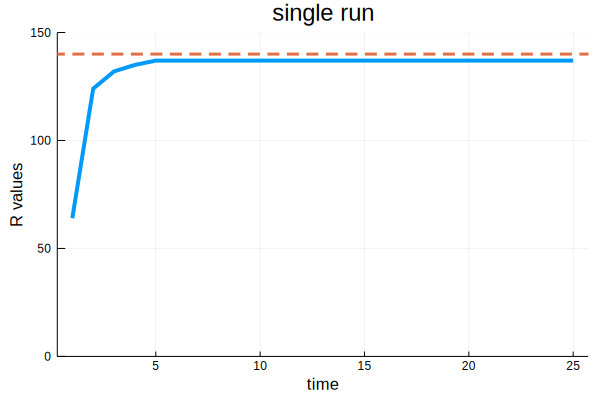

In [57]:

traceR = Int[]

for tt in 1:TT    
    append!(traceR,grid_satisfaction(gridDict[tt]))    
end
println(traceR)
println(typeof(traceR))
plt = plot(traceR,ylim=(0,R_MAX+10),leg=false,linewidth=4,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")

#plot(traceR,ylim=(0,R_MAX+10),leg=false,guidefont=14,linewidth=4,xtickfontsize=10,ytickfontsize=10,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")
hline!([R_MAX],line=(3,:dash),leg=false)

(25, 10)
[61.8; 126.9; 134.5; 137.4; 138.6; 138.5; 138.9; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5; 139.5]


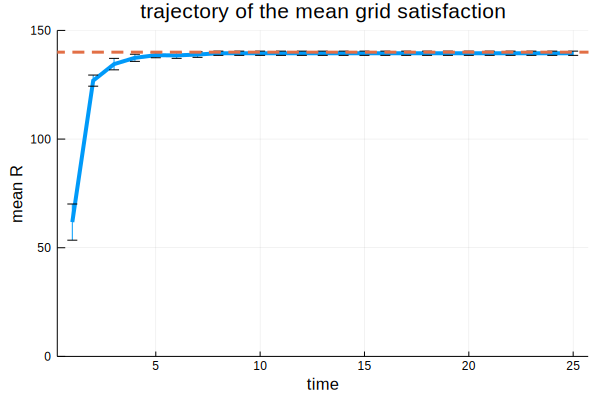

In [58]:
savefig(plt,"figs/singleRun.png")


simulationRvals = zeros(TT,MM)
for mm in 1:MM
    newGrid = shuffle(empty_grid)
    traceR = []
    append!(traceR,grid_satisfaction(newGrid))#initial time zero point
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        append!(traceR,grid_satisfaction(newGrid))
    end
    simulationRvals[:,mm] = traceR[:]

end
    

println(size(simulationRvals))
println(mean(simulationRvals,dims=2))
plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)

In [59]:
savefig(plt,"figs/multipleRun.png")


println(simulationRvals[end,:])

[139.0, 140.0, 140.0, 137.0, 139.0, 140.0, 140.0, 140.0, 140.0, 140.0]


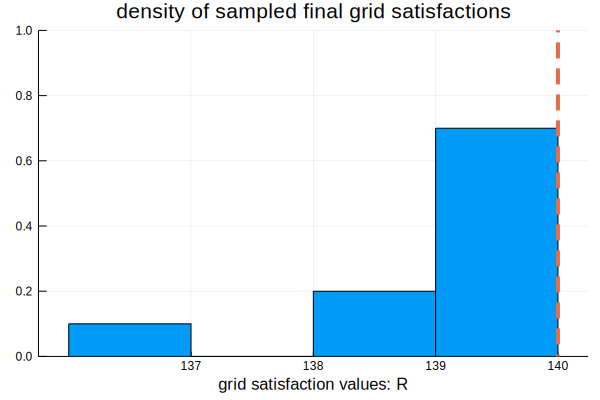

In [60]:
#get the histogram of the final values

pltHist = histogram(simulationRvals[end,:] .- 1,ylim=(0,1.0),xticks = (minimum(simulationRvals[end,:]):maximum(simulationRvals[end,:])) ,normalize=:probability,title="density of sampled final grid satisfactions",xlabel="grid satisfaction values: R",leg=false)#,xlim=(0,R_MAX+10)
vline!([R_MAX],line=(4,:dash),leg=false)



In [61]:
savefig(pltHist,"figs/finalHistRvals.png")


#sample random microstates
numberOfRandomSamples = 15000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]

#set the macrostate count array to those random allocations 
sampleCountsR = [length(findall(randomSatisfactions .== R)) for R in 1:R_MAX]
#println(sampleCountsR)
replace!(sampleCountsR,0=>1)
#println(sampleCountsR)
sampleProbR = sampleCountsR ./ sum(sampleCountsR)
#println(sampleProbR)
#println(sum(sampleProbR))

#The cellspace for the macrostates is the multiple of the probability
sampleOmegaR = sampleProbR .* CELLS_SPACE_SIZE
#println(sampleOmegaR)


println(sampleOmegaR)
println(size(sampleOmegaR))

BigFloat[2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 4.46286e+69, 2.23143e+69, 1.11571e+70, 6.69428e+69, 1.562e+70, 1.33886e+70, 3.124e+70, 4.01657e+70, 4.90914e+70, 9.14885e+70, 1.20497e+71, 1.51737e+71, 1.65126e+71, 2.27606e+71, 2.47688e+71, 4.5298e+71, 4.59674e+71, 6.29263e+71, 6.8728e+71, 7.29677e+71, 8.9034e+71, 1.10902e+72, 1.16481e+72, 1.34332e+72, 1.43035e+72, 1.49059e+72, 1.73382e+72, 1.63341e+72, 1.73382e+72, 1.73828e+72, 1.67134e+72, 1.62225e+72, 1.63117e+72, 1.47051e+72, 1.27191e+72, 1.23175e+72, 1.08224e+72, 9.43894e+71, 8.10008e+71, 6.98437e+71, 5.60088e+71, 4.95377e+71, 4.15046e+71, 3.14631e+71, 2.47688e+71, 1.69589e+71, 1.0934e+71, 9.14885e+70, 5.57857e+70, 4.90914e+70

BigFloat[2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.2142e-21, 2.20463e-21, 2.22685e-21, 2.2198e-21, 2.2315e-21, 2.22937e-21, 2.24107e-21, 2.24454e-21, 2.24731e-21, 2.25591e-21, 2.25971e-21, 2.26289e-21, 2.26406e-21, 2.26849e-21, 2.26966e-21, 2.27799e-21, 2.27819e-21, 2.28253e-21, 2.28375e-21, 2.28457e-21, 2.28732e-21, 2.29035e-21, 2.29103e-21, 2.293e-21, 2.29387e-21, 2.29444e-21, 2.29652e-21, 2.2957e-21, 2.29652e-21, 2.29656e-21, 2.29602e-21, 2.2956e-21, 2.29568e-21, 2.29425e-21, 2.29225e-21, 2.2918e-21, 2.29002e-21, 2.28813e-21, 2.28602e-21, 2.28397e-21, 2.28092e-21, 2.27923e-21, 2.27678e-21, 2.27296e-21, 2.26966e-21, 2.26443e-21, 2.25837e-21, 2.25591e-21, 2.24908e-21, 2.24731e-21

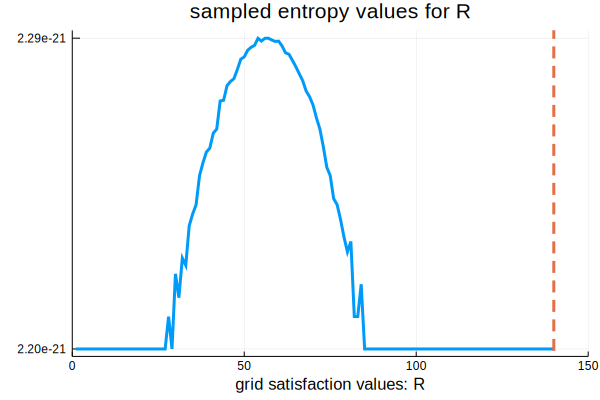

In [62]:
plt2 = plot(1:R_MAX,sampleOmegaR,xlim=(0,R_MAX+10),linewidth=3,title="sampled omega size for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)
savefig(plt2,"figs/sampledOmega.png")



function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end

entropyVals = [S_entropy_values_from_R(R) for R in 1:R_MAX]

println(entropyVals)
println(S_entropy_values_from_R(1),"---",S_entropy_values_from_R(round(Int,R_MAX/2)))

minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt4 = plot(1:R_MAX,entropyVals,
    yticks=([minimum(entropyVals),maximum(entropyVals)],[labelMin,labelMax]),
    xlim=(0,R_MAX+10),ylim=(minimum(entropyVals)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyVals)),
    linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

Any[57, 126, 134, 137, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139]
Any[2.29656e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21]
-9.192376292470415149431052546844674232323519498105113794724392168019547888527269e-23
2.29e-212.20e-21


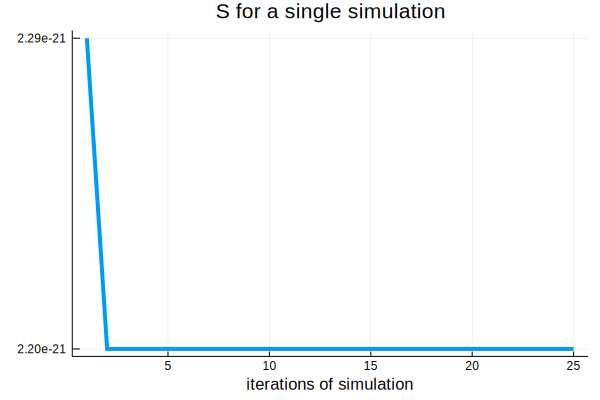

In [63]:
#plt3 = plot(1:R_MAX,entropyVals,xlim=(0,R_MAX+10),linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
#vline!([R_MAX],line=(3,:dash),leg=false)
#savefig(plt3,"figs/sampledEntropy.png"
savefig(plt4,"figs/sampledEntropy.png")


#now do a single run trace with the entropy values and plot
traceR = Int[]
traceS = Int[]

newGrid = shuffle(empty_grid)
traceR = []
traceS = []
Rtmp = grid_satisfaction(newGrid)
append!(traceR,Rtmp)
append!(traceS,S_entropy_values_from_R(Rtmp))
for tt in 2:TT
    newGrid = move_cells_for_satisfaction(newGrid)
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
end
println(traceR)
println(traceS)

println( minimum(traceS) - maximum(traceS)   )


minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(traceS,yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),ylims=(minimum(traceS)*(1-(10^-3)),(1 + 10^-3)*maximum(traceS)),
    linewidth=4,title="S for a single simulation",xlabel="iterations of simulation",leg=false)


In [64]:
savefig(plt5,"figs/entropySingleSimulation.png")



(25, 10)
2.29e-212.20e-21


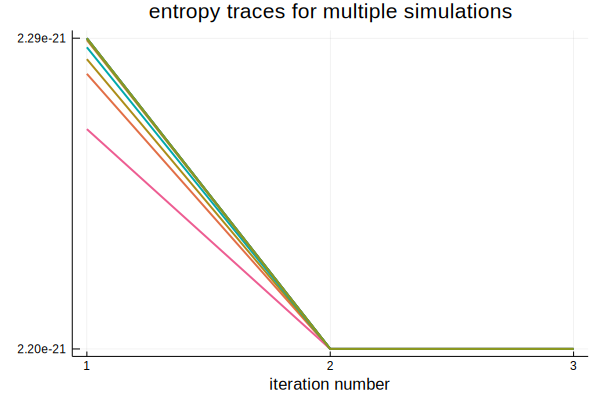

In [65]:


simulationSvals = zeros(TT,MM)
for mm in 1:MM
    traceR = Int[]
    traceS = Int[]

    newGrid = shuffle(empty_grid)
    traceR = []
    traceS = []
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        Rtmp = grid_satisfaction(newGrid)
        append!(traceR,Rtmp)
        append!(traceS,S_entropy_values_from_R(Rtmp))
    end
    simulationSvals[:,mm] = traceS[:]

end

println(size(simulationSvals))
minimumS = minimum(simulationSvals)
maximumS = maximum(simulationSvals)



minStr = string(minimum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(simulationSvals)) )
tmp2 = string(minimum(simulationSvals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(simulationSvals)) )
tmp2 = string(maximum(simulationSvals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt7 = plot(simulationSvals[1:3,1:end],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=2,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


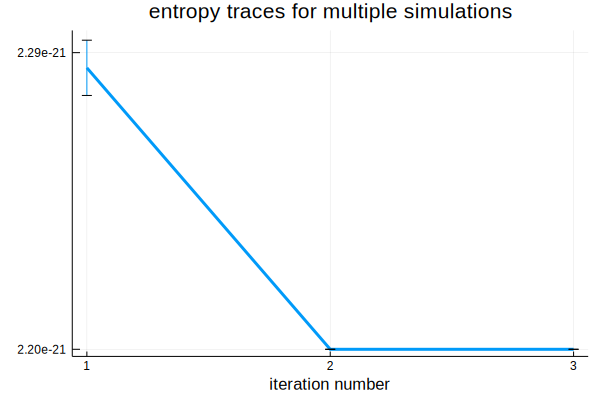

In [66]:
savefig(plt7,"figs/entropyMultipleSimulations.png")


plt8 = plot(mean(simulationSvals,dims=2)[1:3],
    yerr=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 



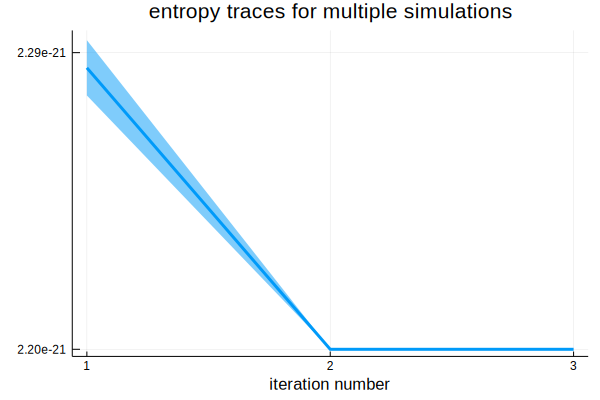

In [67]:
savefig(plt8,"figs/entropyMultipleSimulationsSpread.png")


plt9 = plot(mean(simulationSvals,dims=2)[1:3],
    ribbon=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


In [68]:
savefig(plt9,"figs/entropyMultipleSimulationsSpreadRibbon.png")




In [69]:
##################
#FINANCE PART NOW!
##################


#wealth distribution data taken from: https://raw.githubusercontent.com/jkeesh/which-percent/master/data.csv
# It is based on data from the US census as well as the Social Security Administration
csvWealth = CSV.File("wealthDistribution.csv",header=false)
dfWealth = DataFrame(csvWealth)
percs = dfWealth[:,4]
percsNew=[percs[i][1:end-1] for i in 1:length(percs)]
percsNewNew = [ parse(Float64,percsNew[i]) for i in 1:length(percs)]

#produces the 2 column data for the percentage that has more than a certain amount
function df2wealthArray(dfWealth)
    meansBracket = []
    for i in 1:size(dfWealth)[1]
        
        inds = findall(isequal(' '),dfWealth[i,1])
        
        money1 = dfWealth[i,1][1:inds[1]-1]
        money2 = dfWealth[i,1][inds[2]+1:end]
        
        
        
        if(i == size(dfWealth)[1])
            money2 = money1
        end
        
        money1 = replace(money1,","=>"")
        money2 = replace(money2,","=>"")
        money1 = parse(Float64,money1)
        money2 = parse(Float64,money2)
        
        #println(mean([money1,money2]))
        append!(meansBracket,mean([money1,money2]))
        
    end
    return meansBracket
end
wealthBrackets = df2wealthArray(dfWealth)
percsAndWealth = hcat(percsNewNew,wealthBrackets) 
println(percsAndWealth)
println(percsAndWealth[1,:])


Any[100.0 2500.0; 85.7293 7499.99; 76.9745 12500.0; 69.1804 17500.0; 61.9069 22500.0; 55.0045 27500.0; 48.561 32500.0; 42.5631 37500.0; 37.1403 42500.0; 32.3649 47500.0; 28.2287 52500.0; 24.6107 57500.0; 21.5469 62500.0; 18.891 67500.0; 16.632 72500.0; 14.6756 77500.0; 12.9786 82500.0; 11.5263 87500.0; 10.2775 92500.0; 9.1938 97500.0; 8.254 102500.0; 7.4264 107500.0; 6.7202 112500.0; 6.1026 117500.0; 5.5552 122500.0; 5.0663 127500.0; 4.6402 132500.0; 4.2636 137500.0; 3.9302 142500.0; 3.635 147500.0; 3.3701 152500.0; 3.127 157500.0; 2.915 162500.0; 2.7278 167500.0; 2.5601 172500.0; 2.4087 177500.0; 2.272 182500.0; 2.1452 187500.0; 2.032 192500.0; 1.9275 197500.0; 1.8301 225000.0; 1.1727 275000.0; 0.8155 325000.0; 0.6046 375000.0; 0.4656 425000.0; 0.37 475000.0; 0.3012 750000.0; 0.0825 1.25e6; 0.0411 1.75e6; 0.0258 2.25e6; 0.0182 2.75e6; 0.0138 3.25e6; 0.0108 3.75e6; 0.0087 4.25e6; 0.0072 4.75e6; 0.0061 7.5e6; 0.002 1.5e7; 0.0006 3.5e7; 0.0001 5.0e7]
Any[100.0, 2500.0]


In [70]:
#now sample according to the population a wealth bracket to produce a wealth number from the data

function wealthBracketSample()
    brackets = findall(isequal(true), rand()*100 .<= percsAndWealth[:,1] )
    maxBracketInd = maximum(brackets)
    #println(maxBracketInd)
    return percsAndWealth[maxBracketInd,2]
end

wealthSamples = [wealthBracketSample() for i in 1:10]
println(wealthSamples)


[52500.0, 17500.0, 12500.0, 112500.0, 47500.0, 77500.0, 12500.0, 2500.0, 12500.0, 32500.0]


--yellow mean--40964.28571428572--blue mean--41178.57142857143
std yellow sample 58252.46909170033
std blue sample 48140.64808381381
skewness yellow sample 4.4061956413414265
skewness blue sample 2.317241946776576


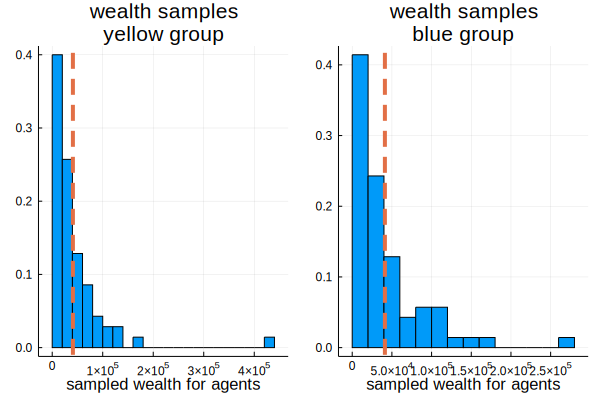

In [71]:

wealthSamplesYellow = [wealthBracketSample() for i in 1:yellow_count]
wealthSamplesYellow = round.(wealthSamplesYellow)
wealthSamplesBlue = [wealthBracketSample() for i in 1:blue_count]
wealthSamplesBlue = round.(wealthSamplesBlue)

println("--yellow mean--",mean(wealthSamplesYellow),"--blue mean--",mean(wealthSamplesBlue))

println("std yellow sample $(std(wealthSamplesYellow))")
println("std blue sample $(std(wealthSamplesBlue))")
println("skewness yellow sample $(skewness(wealthSamplesYellow))")
println("skewness blue sample $(skewness(wealthSamplesBlue))")

pltHistYellow = histogram(wealthSamplesYellow,normalize=:probability,title="wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellow)],line=(4,:dash),leg=false)

pltHistBlue = histogram(wealthSamplesBlue,normalize=:probability,title="wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlue)],line=(4,:dash),leg=false)

plt2hist = plot(pltHistYellow,pltHistBlue)

[52500.0, 27500.0, 27500.0, 2500.0, 47500.0, 32500.0, 17500.0, 7500.0, 22500.0, 27500.0, 2500.0, 7500.0, 2500.0, 17500.0, 2500.0, 12500.0, 52500.0, 62500.0, 7500.0, 2500.0, 2500.0, 12500.0, 27500.0, 7500.0, 22500.0, 37500.0, 67500.0, 22500.0, 2500.0, 67500.0, 12500.0, 32500.0, 32500.0, 2500.0, 27500.0, 162500.0, 2500.0, 57500.0, 17500.0, 22500.0, 57500.0, 22500.0, 7500.0, 42500.0, 425000.0, 42500.0, 97500.0, 67500.0, 2500.0, 27500.0, 62500.0, 62500.0, 2500.0, 2500.0, 7500.0, 42500.0, 82500.0, 32500.0, 32500.0, 17500.0, 12500.0, 42500.0, 132500.0, 27500.0, 107500.0, 102500.0, 2500.0, 92500.0, 7500.0, 127500.0, 62500.0, 32500.0, 92500.0, 7500.0, 2500.0, 2500.0, 12500.0, 52500.0, 22500.0, 7500.0, 77500.0, 57500.0, 22500.0, 117500.0, 42500.0, 42500.0, 22500.0, 2500.0, 2500.0, 37500.0, 275000.0, 37500.0, 7500.0, 7500.0, 87500.0, 12500.0, 2500.0, 2500.0, 7500.0, 7500.0, 17500.0, 132500.0, 7500.0, 67500.0, 47500.0, 97500.0, 12500.0, 17500.0, 52500.0, 2500.0, 2500.0, 7500.0, 42500.0, 7500.0, 3

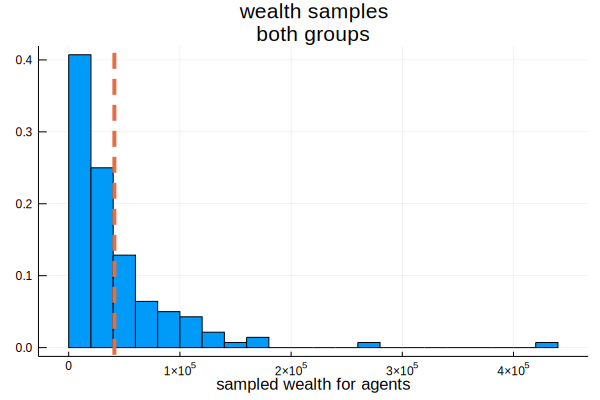

In [72]:

savefig(plt2hist,"figs/histwealthYellow.png")

totalWealthSamples = [wealthSamplesYellow ; wealthSamplesBlue]
println(totalWealthSamples)
println(size(totalWealthSamples))

pltHistTotal = histogram(totalWealthSamples,normalize=:probability,title="wealth samples \n both groups",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(totalWealthSamples)],line=(4,:dash),leg=false)


--yellowNormed mean--0.014285714285714285--blueNormed mean--0.014285714285714289
std yellowNormed sample 0.020314723310096018
std blueNormed sample 0.016701005406353445
skewness yellowNormed sample 4.406195641341429
skewness blueNormed sample 2.317241946776574


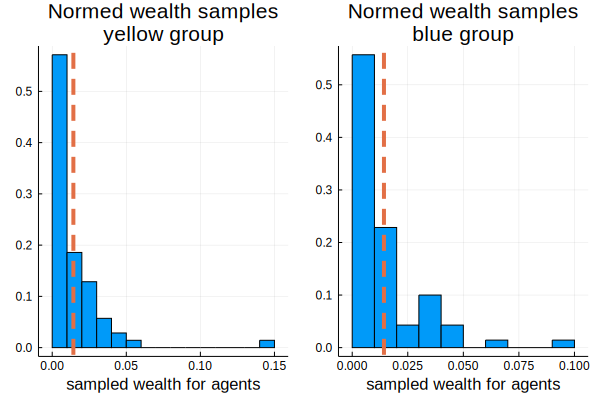

In [73]:

savefig(pltHistTotal,"figs/histwealthTotal.png")

wealthSamplesYellowNormed = wealthSamplesYellow ./ sum(wealthSamplesYellow)
wealthSamplesBlueNormed = wealthSamplesBlue ./ sum(wealthSamplesBlue)

println("--yellowNormed mean--",mean(wealthSamplesYellowNormed),"--blueNormed mean--",mean(wealthSamplesBlueNormed))

println("std yellowNormed sample $(std(wealthSamplesYellowNormed))")
println("std blueNormed sample $(std(wealthSamplesBlueNormed))")
println("skewness yellowNormed sample $(skewness(wealthSamplesYellowNormed))")
println("skewness blueNormed sample $(skewness(wealthSamplesBlueNormed))")

pltHistYellowNormed = histogram(wealthSamplesYellowNormed,normalize=:probability,title="Normed wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellowNormed)],line=(4,:dash),leg=false)

pltHistBlueNormed = histogram(wealthSamplesBlueNormed,normalize=:probability,title="Normed wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlueNormed)],line=(4,:dash),leg=false)

plotNormedHists = plot(pltHistYellowNormed,pltHistBlueNormed)


In [74]:
savefig(plotNormedHists,"figs/histwealthYellow.png")


In [95]:
#in the finance grid we store both the type of agent and the financial part
#sample wealths, non-normed and then norm or not, and set random positions for agent types, apply the 
#normed wealths randomly
function make_random_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    wealthSamplesYellow = [wealthBracketSample() for i in 1:yellow_count]
    wealthSamplesYellow = round.(wealthSamplesYellow)
    wealthSamplesBlue = [wealthBracketSample() for i in 1:blue_count]
    wealthSamplesBlue = round.(wealthSamplesBlue)
    
    
    NORMED = true
    if(NORMED == true)
        samplesYellow = wealthSamplesYellow ./ sum(wealthSamplesYellow)
        samplesBlue = wealthSamplesBlue ./ sum(wealthSamplesBlue)
    else
        samplesYellow = wealthSamplesYellow #./ sum(wealthSamplesYellow)
        samplesBlue = wealthSamplesBlue #./ sum(wealthSamplesBlue)
    end
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= samplesYellow
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= samplesBlue
    
    indShuffle = shuffle(1:GRID_SIZE^2)
    indShuffleShift = indShuffle .+ GRID_SIZE^2
    empty_grid[1:GRID_SIZE^2] = empty_grid[indShuffle]
    empty_grid[1 .+ GRID_SIZE^2 : GRID_SIZE^2 .+ GRID_SIZE^2 ] = empty_grid[indShuffleShift]
    #empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    
    return empty_grid
end
#spatial and financial
moneyGrid = make_random_finance_grid()
println(moneyGrid)
println(sum(moneyGrid))
println(length(findall(moneyGrid[:,:,2] .!= 0)))
b1 = (moneyGrid[:,:,2] .== 0.0)
b2 = (moneyGrid[:,:,1] .== 0.0)
println(count(isequal.(b1,b2)))
println("cool if true...=$(count(isequal.(b1,b2))==GRID_SIZE^2)")

[-1.0 -1.0 1.0 -1.0 -1.0 -1.0 0.0 1.0 1.0 0.0 1.0 -1.0 1.0; -1.0 1.0 -1.0 0.0 1.0 0.0 -1.0 -1.0 1.0 1.0 1.0 0.0 -1.0; -1.0 -1.0 1.0 1.0 1.0 -1.0 0.0 0.0 1.0 1.0 1.0 -1.0 1.0; 1.0 -1.0 -1.0 1.0 1.0 -1.0 1.0 -1.0 -1.0 1.0 1.0 1.0 -1.0; 1.0 1.0 1.0 1.0 -1.0 0.0 1.0 0.0 1.0 -1.0 -1.0 1.0 0.0; -1.0 1.0 -1.0 1.0 -1.0 -1.0 -1.0 0.0 1.0 0.0 1.0 -1.0 1.0; -1.0 -1.0 1.0 -1.0 -1.0 1.0 -1.0 1.0 0.0 -1.0 -1.0 -1.0 0.0; 0.0 -1.0 1.0 -1.0 0.0 1.0 0.0 -1.0 1.0 -1.0 -1.0 1.0 0.0; 1.0 -1.0 0.0 -1.0 -1.0 -1.0 0.0 -1.0 -1.0 1.0 0.0 1.0 -1.0; 1.0 1.0 -1.0 1.0 1.0 1.0 -1.0 -1.0 -1.0 -1.0 -1.0 1.0 -1.0; 1.0 0.0 -1.0 0.0 -1.0 -1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0; -1.0 1.0 1.0 -1.0 0.0 0.0 -1.0 0.0 1.0 -1.0 1.0 -1.0 0.0; 0.0 1.0 -1.0 1.0 -1.0 1.0 1.0 -1.0 1.0 -1.0 1.0 -1.0 1.0]

[0.00396825 0.0198413 0.0338866 0.0230159 0.00714286 0.034127 0.0 0.00622407 0.00760719 0.0 0.0200553 0.0388889 0.0159059; 0.00714286 0.0311203 0.018254 0.0 0.00899032 0.0 0.0166667 0.0119048 0.0117566 0.0117566 0.0103734 0.0 0.0420635; 0.

In [96]:
#get the financial surroundings
#pass the grid and provide the cell to get the surrounding finance or type array
function cell_surround_arrayTMP_financial(gridFull,row,col,third)
    grid = gridFull[:,:,third]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end
arrayCellFinance = cell_surround_arrayTMP_financial(moneyGrid,11,12,2)
println(arrayCellFinance)
arrayCellType = cell_surround_arrayTMP_financial(moneyGrid,11,12,1)
println(arrayCellType)

Any[0.0714286, 0.0117566, 0.000793651, 0.00345781, 0.00345781, 0.00484094, 0.00396825, 0.0]
Any[-1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 0.0]


In [97]:

#the equivalent of 'thresholdFN' that examines a locality to see financial deviation
#give the full grid, the surrounding array for the finance and return the MAD in this case
function financial_cell_deviation(gridFull,cellSurroundArray,row,col)
    cellFinance = gridFull[row,col,2]
    if(cellFinance == 0)
        return 0
    end
    #println(cellFinance)    
    deviation = mad(cellSurroundArray,center=cellFinance,normalize=false)
    return deviation
    
end

moneyDeviation = financial_cell_deviation(moneyGrid,arrayCellFinance,11,12)
println(moneyDeviation)
println(moneyGrid[11,12,2])


0.0030214713824672328
0.0006915629322268327


In [99]:
#find the total deviation for the cells finances
#find all the financial deviations accross all the cells and aggregate
function financial_grid_deviation(gridFull)
    #grid = gridFull[:,:,2]
    cell_deviation = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            arrayCellFinance = cell_surround_arrayTMP_financial(gridFull,row,col,2)
            #t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            moneyDeviation = financial_cell_deviation(gridFull,arrayCellFinance,row,col)
            #tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_deviation,moneyDeviation)
        end
    end    
    return sum(cell_deviation)    
    
end
gridDeviationMedians = financial_grid_deviation(moneyGrid);
println(gridDeviationMedians)
println("yay")
 
x = [financial_grid_deviation(make_random_finance_grid()) for i in 1:100]
println(mean(x))
println("min MAD of financial deviations of full grids=",minimum(x))
println("max MAD of financial deviations of full grids=",maximum(x))

1.7918296779292608
yay
1.815918820962209
min MAD of financial deviations of full grids=1.602231513925513
max MAD of financial deviations of full grids=1.969884851321645


mean of the deviations for the sampled= 1.8128679667610486


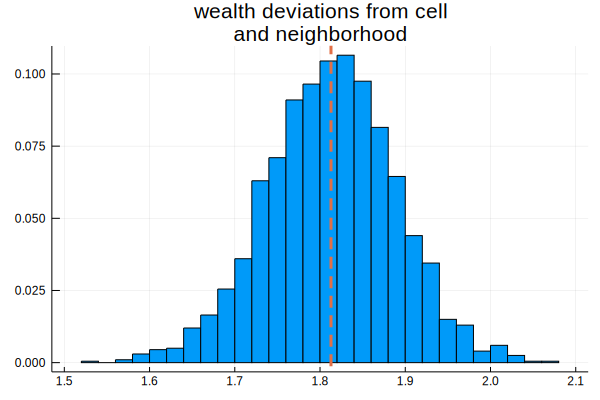

In [79]:
#try running the random deviations over a set to see the distribution
numberOfRandomSamples = 2000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,
    title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)



[0.0205238, 0.153725, 0.718463, 0.796962, 0.307447, 0.0659492, 0.23723, 0.948627, 0.968374, 0.1061]
[0.00487543, 0.0196272, 0.0120162, 0.0134183, 0.0220017, 0.00549407, 0.0158763, 0.0295995, 0.016554, 0.0102159, 0.00673825, 0.0202773, 0.005404, 0.0291253, 0.0237855, 0.00227761, 0.00970097, 0.0143477, 0.0147887, 0.0154451, 0.00171915, 0.00837109, 0.0108033, 0.0154706, 0.000912187, 0.0157907, 0.0269314, 0.000683842, 0.015774, 0.0166172, 0.0274461, 0.0102194, 0.0103273, 0.011054, 0.00379519, 0.00393102, 0.0207284, 0.0200617, 0.026273, 0.018852, 0.0261594, 0.0230544, 0.0290088, 0.0144895, 0.000361135, 0.0249448, 0.0291221, 0.026872, 0.00671561, 0.0120092, 0.00217173, 0.0137581, 0.0138671, 0.0287688, 0.0273404, 0.0017601, 0.00163291, 0.00533983, 0.00790103, 0.0103698, 0.0150974, 0.0199622, 0.00593587, 0.00814907, 0.0146388, 0.0206453, 0.00859328, 0.0183004, 0.0174773, 0.00822307]
1.9999999999999973
mean of the deviations for he uniform sampled= 1.3552201588490396


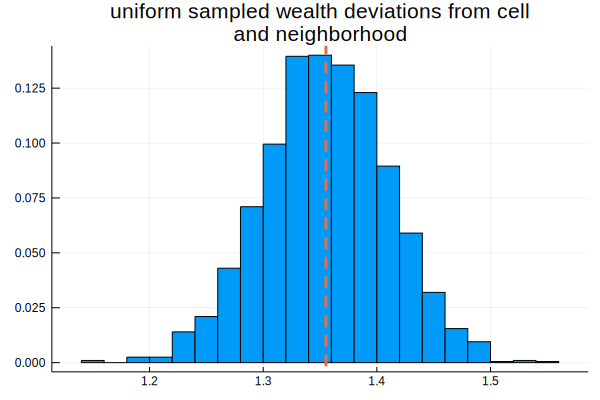

In [80]:
savefig(pltHist,"figs/histwealthSampleDeviations.png")

function randUniformWealthBracketSample()
    #row = Int(round(rand() * size(percsAndWealth)[1]))
    return rand()
end

wealthSamples = [randUniformWealthBracketSample() for i in 1:10]
println(wealthSamples)


#in the finance grid we store both the type of agent and the financial part
yellowUniformSample = [randUniformWealthBracketSample() for i in 1:yellow_count]
blueUniformSample = [randUniformWealthBracketSample() for i in 1:blue_count]

NORMED = true

if(NORMED == true)
    wealthSamplesYellowUniformSampled = yellowUniformSample ./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample ./ sum(blueUniformSample)
    println(wealthSamplesBlueUniformSampled)
else
    wealthSamplesYellowUniformSampled = yellowUniformSample #./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample# ./ sum(blueUniformSample)
end

    
function make_uniform_sampled_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= wealthSamplesYellowUniformSampled
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= wealthSamplesBlueUniformSampled
    
    empty_grid[:,:,1] = shuffle(empty_grid[:,:,1])
    empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    return empty_grid
end

moneyGridUniformSampled = make_uniform_sampled_finance_grid()
println(sum(moneyGridUniformSampled))


randomUniformMoneyDeviations = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealUniformMoneyDeviations = mean(randomUniformMoneyDeviations)

println("mean of the deviations for he uniform sampled= $(mean(randomUniformMoneyDeviations))")
pltHistUniform = histogram(randomUniformMoneyDeviations,leg=false,normalize=:probability,title="uniform sampled wealth deviations from cell\n and neighborhood")
vline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)


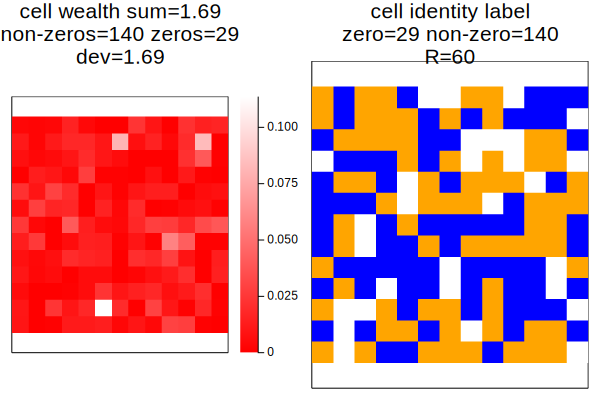

1


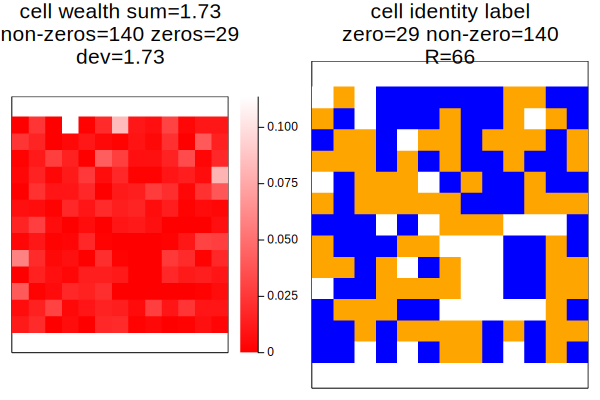

2


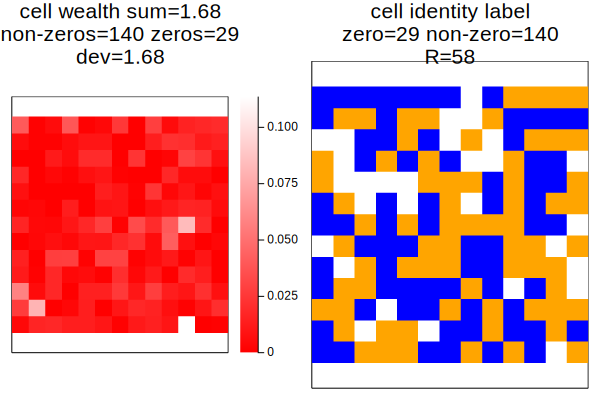

3


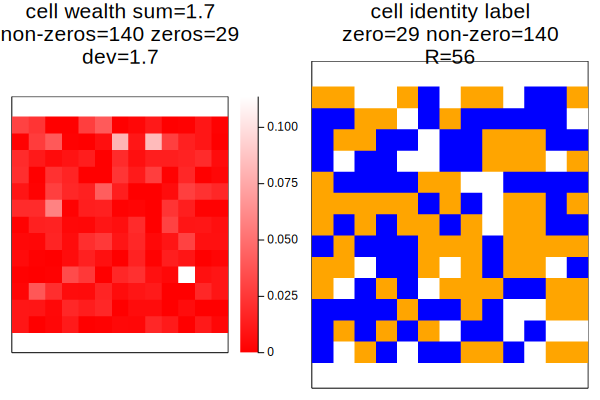

4


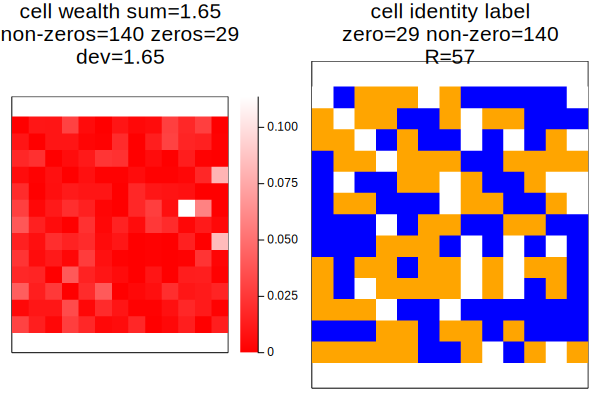

5


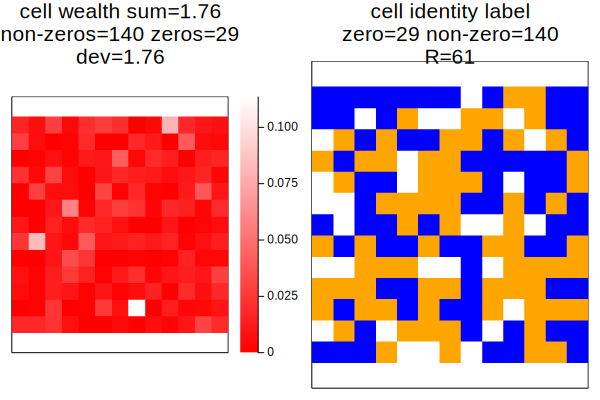

6


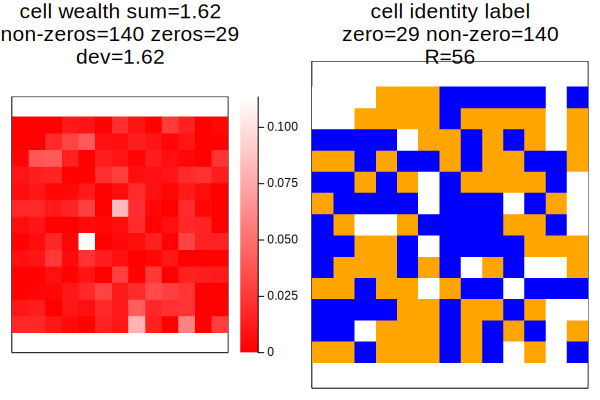

7


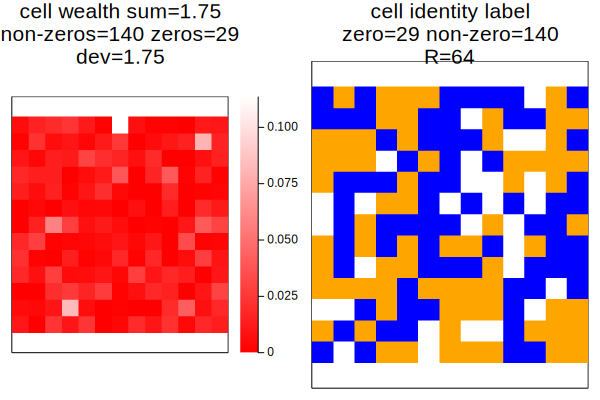

8


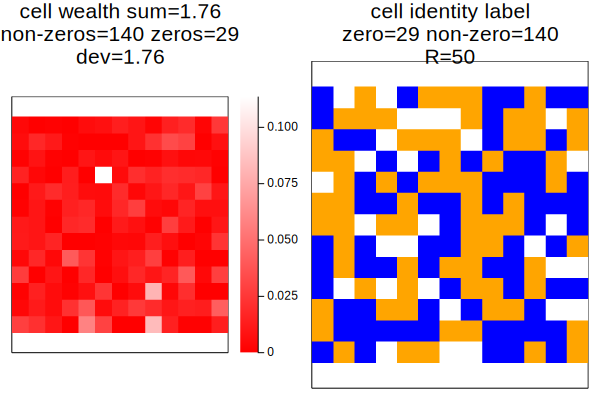

9


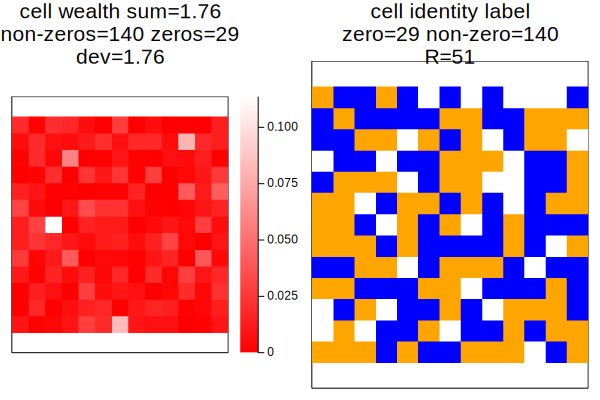

10


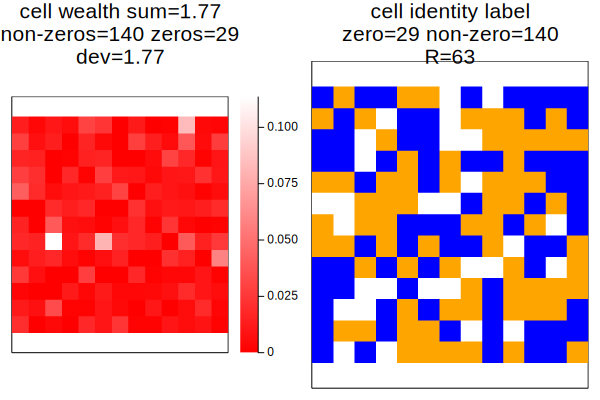

11


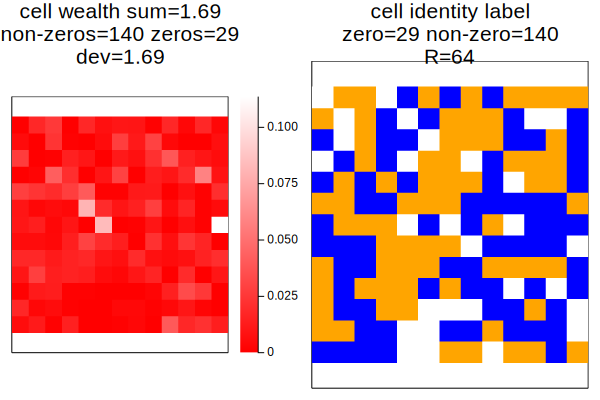

12


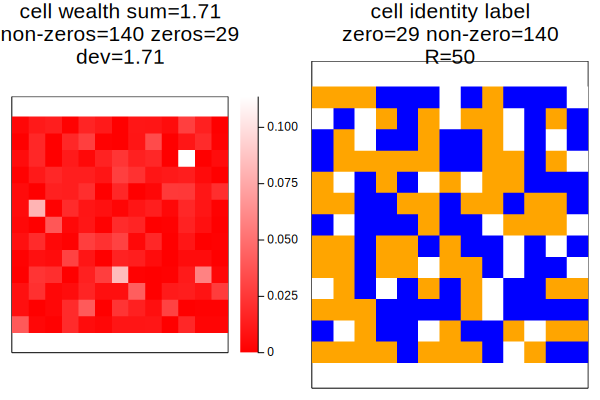

13


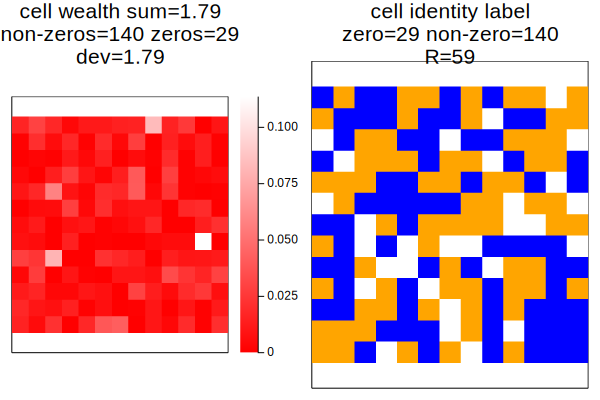

14


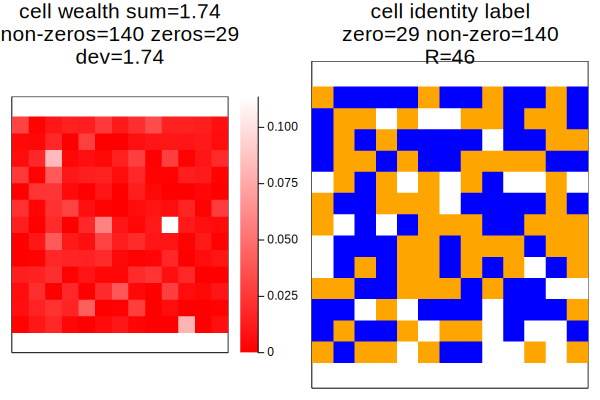

15


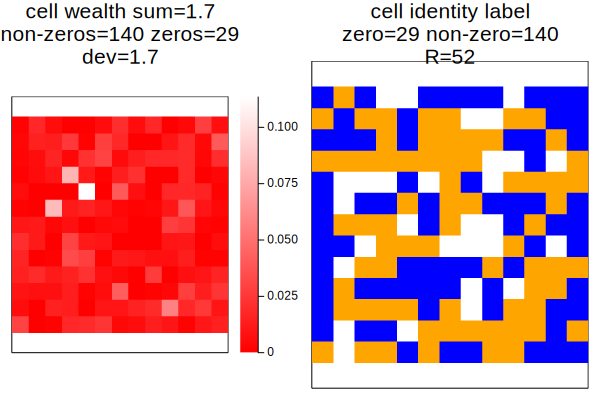

16


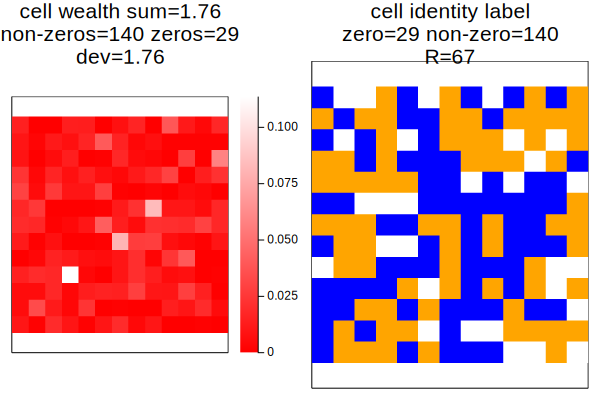

17


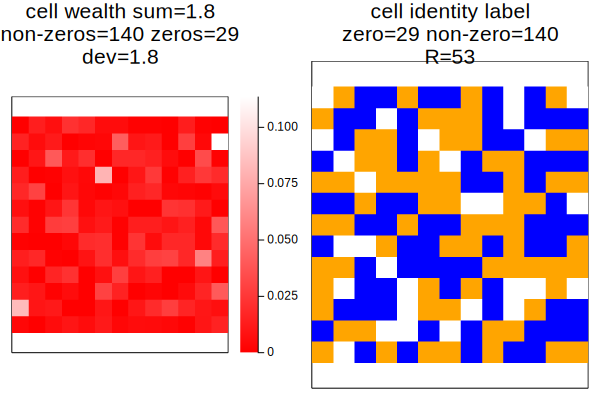

18


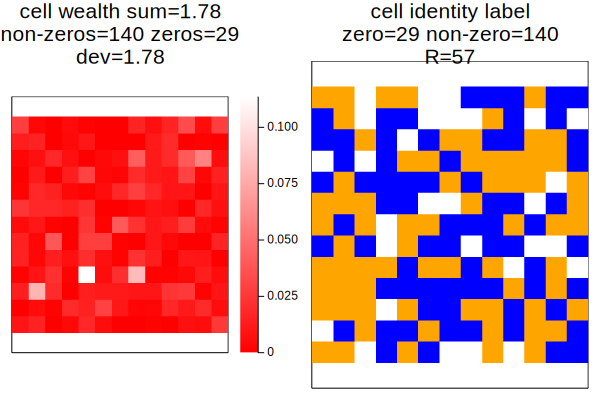

19


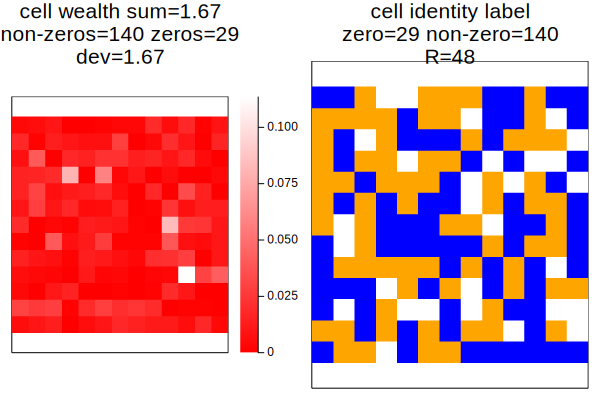

20


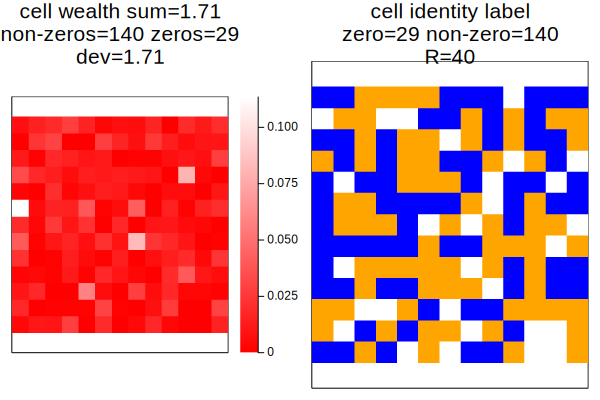

21


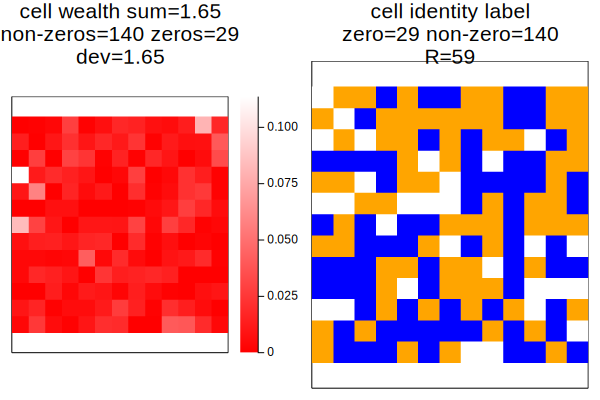

22


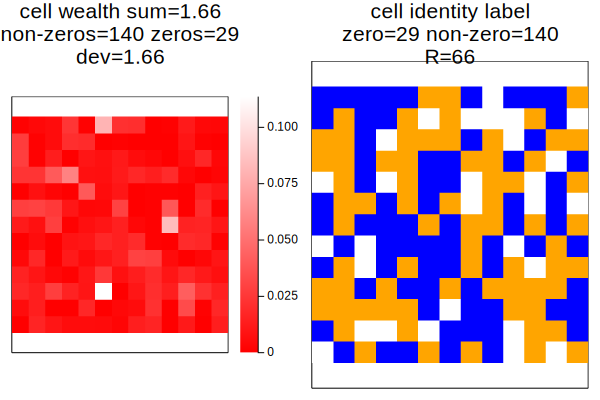

23


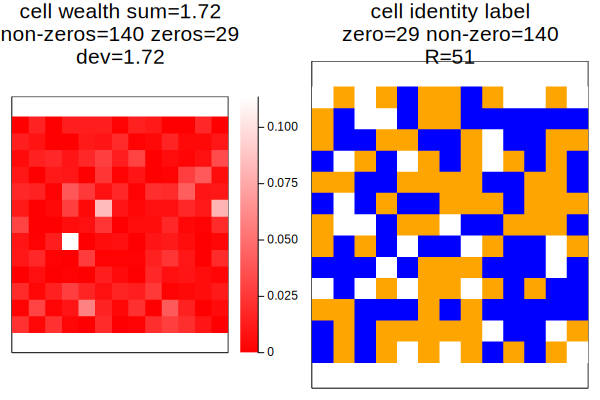

24


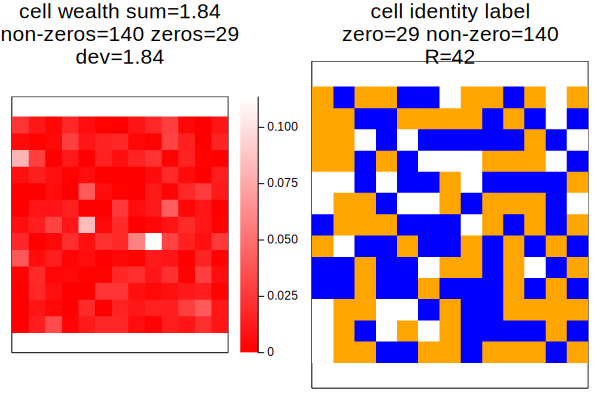

25
---produce random financial grids and then financial grids no movements to see hopefully no differences
x=1.7912236300824596
x2=1.7998722068562656


In [101]:
savefig(pltHistUniform,"figs/histwealthUniformSampleDeviations.png")


#wealth no dynamics just moves the cells around randomly and continuously and at each iteration check the 
#financial cell deviation at each iteration, and at each move ...
##<pick a random percentage of the wealth and radiate that amongst the neighbors
function move_cells_for_wealth_NoDynamics(grid)
    
    #grid = deepcopy(gridOrig) 
    
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
        
    
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0             
           
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        #radiate the finance randomly on the surroundings
        #grid = cell_surround_radiate_financialRandomUniform!(grid,ec[1],ec[2])
        
            
    end          
    #println(g2[:,:,1] == newGrid2[:,:,1])
    return grid
end

traceR = zeros(TT)
traceWD = zeros(TT)
 
for tt in 1:TT   
    println(tt)
    if(tt==1)
        moneyGrid = make_random_finance_grid()  
    else
        moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
    end
    
        
    traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceWD[tt] = financial_grid_deviation(moneyGrid)
    wdevTmp = financial_grid_deviation(moneyGrid)
    Rtmp = grid_satisfaction(moneyGrid[:,:,1])
    tmp = round(sum(wdevTmp),digits=2)
    tmp2 = length(findall(moneyGrid[:,:,1] .!= 0))
    tmp2b = length(findall(moneyGrid[:,:,1] .== 0))
    tmp3 = length(findall(moneyGrid[:,:,2] .== 0))
    tmp4 = length(findall(moneyGrid[:,:,2] .!= 0))
    
    hm = heatmap(moneyGrid[:,:,2],title="cell wealth sum=$(tmp) \n non-zeros=$(tmp4) zeros=$(tmp3) \n dev=$(round(wdevTmp,digits=2))",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
    c=ColorGradient([:red,:white]))
    hm2 = heatmap(moneyGrid[:,:,1],title="cell identity label \n zero=$(tmp2b) non-zero=$(tmp2) \n R=$(Rtmp)",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
        c=ColorGradient([:orange,:white,:blue]))

    p1=plot(hm,hm2)
    display(p1)
    savefig(hm,"figs/simulationSnapShots2/time$(tt).png")
end

println("---produce random financial grids and then financial grids no movements to see hopefully no differences")
x = mean([financial_grid_deviation(make_random_finance_grid()) for i in 1:10])
println("x=$(x)")
x2 = mean([financial_grid_deviation(move_cells_for_wealth_NoDynamics(make_random_finance_grid())) for i in 1:10])
println("x2=$(x2)")

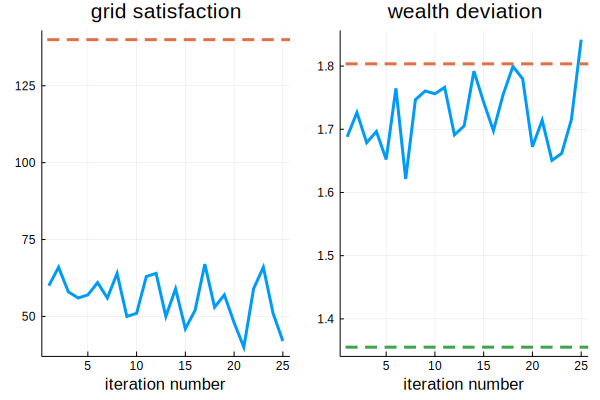

In [105]:


p1 = plot(traceR,linewidth=3,title="grid satisfaction",xlabel="iteration number")
hline!([R_MAX],line=(3,:dash),leg=false)
p2 = plot(traceWD,linewidth=3,title="wealth deviation",xlabel="iteration number")
hline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)
hline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)
pboth = plot(p1,p2)
display(pboth)
savefig(pboth,"figs/RandWealthDevRandomNoDynamics.png")



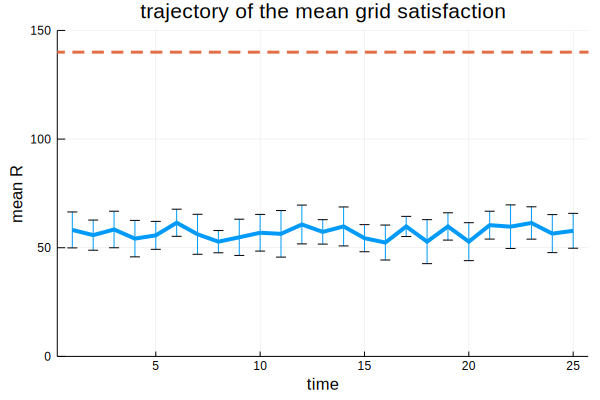

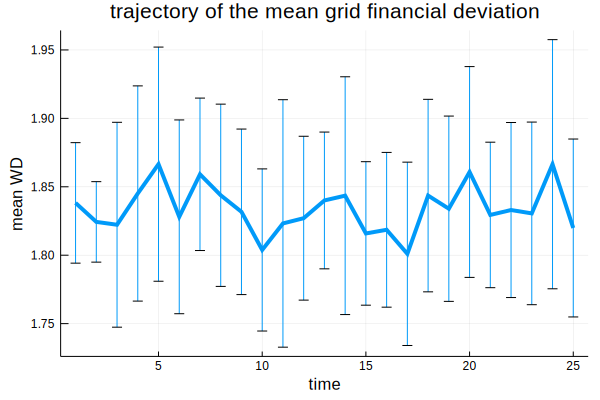

In [121]:


simulationRvals = zeros(TT,MM)
simulationWvals = zeros(TT,MM)
for mm in 1:MM    
    
    traceR = zeros(TT)
    traceWD = zeros(TT)
    for tt in 1:TT   
        #println(tt)
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
        end    

        traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceWD[tt] = financial_grid_deviation(moneyGrid)        

    end

    simulationRvals[:,mm] = traceR[:]
    simulationWvals[:,mm] = traceWD[:]
end
    


 

plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)
display(plt)
savefig(plt,"figs/trajectoryMeanGridSatisfactionWithWealth.png")

plt = plot(mean(simulationWvals,dims=2),xlabel="time",ylabel="mean WD",yerr=std(simulationWvals,dims=2),linewidth=4,title="trajectory of the mean grid financial deviation",leg=false) 
#hline!([R_MAX],line=(3,:dash),leg=false)
display(plt)

savefig(plt,"figs/meanTrajFinancialDeviation.png")

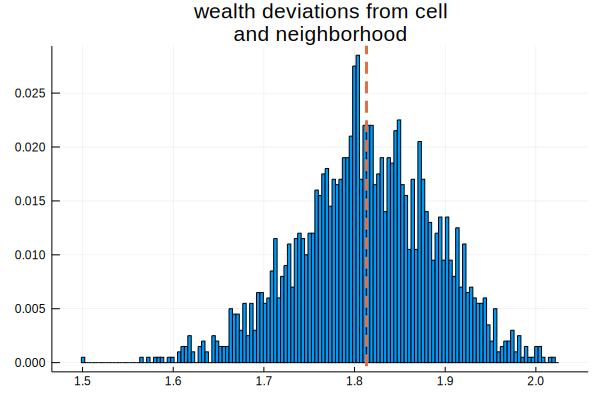

mean of the deviations for the sampled= 1.8132016967527145
3.94
moneyDeviationBins=[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.

Dict(1.2=>0.00178253,2.37=>0.00178253,1.68=>0.00891266,1.19=>0.00178253,0.22=>0.00178253,2.75=>0.00178253,0.2=>0.00178253,0.89=>0.00178253,0.48=>0.00178253,1.35=>0.00178253,2.62=>0.00178253,2.78=>0.00178253,0.24=>0.00178253,2.24=>0.00178253,3.51=>0.00178253,0.11=>0.00178253,2.87=>0.00178253,0.95=>0.00178253,1.55=>0.00178253,2.95=>0.00178253,3.01=>0.00178253,0.08=>0.00178253,2.81=>0.00178253,0.58=>0.00178253,3.22=>0.00178253,2.08=>0.00178253,1.34=>0.00178253,1.78=>0.0249554,2.25=>0.00178253,2.19=>0.00178253,0.81=>0.00178253,1.6=>0.00178253,3.15=>0.00178253,3.86=>0.00178253,2.04=>0.00178253,1.85=>0.0142602,0.4=>0.00178253,0.37=>0.00178253,3.54=>0.00178253,1.65=>0.00356506,2.34=>0.00178253,2.21=>0.00178253,2.4=>0.00178253,2.22=>0.00178253,3.57=>0.00178253,0.99=>0.00178253,2.39=>0.00178253,1.73=>0.0160428,3.49=>0.00178253,2.02=>0.00178253,1.25=>0.00178253,1.21=>0.00178253,1.95=>0.00178253,0.8=>0.00178253,1.05=>0.00178253,2.72=>0.00178253,2.09=>0.00178253,0.5=>0.00178253,0.55=>0.00178253,1.

Dict{Float64,BigFloat} with 395 entries:
  1.2  => 5.99821e+70
  2.37 => 5.99821e+70
  1.68 => 2.9991e+71
  1.19 => 5.99821e+70
  0.22 => 5.99821e+70
  2.75 => 5.99821e+70
  0.2  => 5.99821e+70
  0.89 => 5.99821e+70
  0.48 => 5.99821e+70
  1.35 => 5.99821e+70
  2.62 => 5.99821e+70
  2.78 => 5.99821e+70
  0.24 => 5.99821e+70
  2.24 => 5.99821e+70
  3.51 => 5.99821e+70
  0.11 => 5.99821e+70
  2.87 => 5.99821e+70
  0.95 => 5.99821e+70
  1.55 => 5.99821e+70
  2.95 => 5.99821e+70
  3.01 => 5.99821e+70
  0.08 => 5.99821e+70
  2.81 => 5.99821e+70
  0.58 => 5.99821e+70
  3.22 => 5.99821e+70
  ⋮    => ⋮

In [143]:
#R_MAX
#now compute the sampled distribution for the probability of the different bins
numberOfRandomSamples = 2000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,
    bins=range(minimum(randomMoneyDeviations),stop = maximum(randomMoneyDeviations),length=R_MAX),
    title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)
display(pltHist)
savefig(pltHist,"figs/RawWealthDeviationsSample.png")


#MACROSTATE SEPARATOR parameter manually fixed as a bin size
SEPBIN = 0.01
roundDigits = 2

#now sample deviations for the probability distribution to be produced for the entropy later
numberOfRandomSamples = 200
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviations = round.(randomMoneyDeviations,digits=roundDigits)
#set the maximum macrostate counts to be 
maxDev = round(2 * maximum(randomMoneyDeviations),digits=roundDigits)
println(maxDev)
moneyDeviationBins = collect(range(0,step=SEPBIN,stop=maxDev))
println("moneyDeviationBins=",moneyDeviationBins)
println("size of the moneyDeviationBins=",length(moneyDeviationBins))
#println(randomMoneyDeviations)
binsDevCounts = [length( findall( dev .== randomMoneyDeviations ) ) for dev in moneyDeviationBins]
replace!(binsDevCounts,0=>1)
binsDevCountsProb = binsDevCounts ./ sum(binsDevCounts)
println("binsDevCountsProb=",binsDevCountsProb)
println("size of the moneyDeviationBins=",length(binsDevCountsProb))
binsDev = collect( 0:SEPBIN:length(moneyDeviationBins) .* SEPBIN )

binsAndProbsMoney = hcat(moneyDeviationBins,binsDevCountsProb)
println("binAndProbsMoney=",binsAndProbsMoney)

#DICT FOR THE WEALTH STATE PROB
dictBinsWealthDevProb = Dict(zip(binsDev,binsDevCountsProb))

println(dictBinsWealthDevProb)
println(dictBinsWealthDevProb[1.8])

#DICT FOR THE SAMPLE SPACE
sampleOmegaWD = binsDevCountsProb .* CELLS_SPACE_SIZE
#println(sampleOmegaW)
dictBinsWealthDevOmegaW = Dict(zip(binsDev,sampleOmegaWD))

#println(dictBinsWealthDevOmegaB)
#println(dictBinsWealthDevOmegaB[1.8])
#println(dictBinsWealthDevOmegaB[1.1])



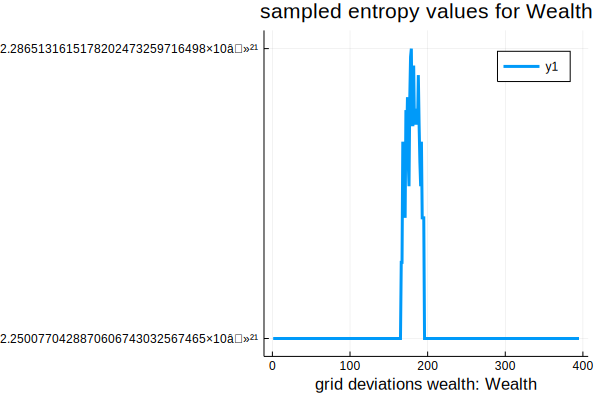

395


In [146]:

function S_entropy_values_from_WD(W)
    return k_b * log(sampleOmegaWD[W])
       
end

entropyValsW = [S_entropy_values_from_WD(W) for W in 1:length(moneyDeviationBins)]
println(length(entropyValsW))
#println((entropyValsW))

pltSW = plot(1:length(moneyDeviationBins),entropyValsW,
    yticks=([minimum(entropyValsW),maximum(entropyValsW)]),
    ylim=(minimum(entropyValsW)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyValsW)),
    linewidth=3,title="sampled entropy values for Wealth",xlabel="grid deviations wealth: Wealth")
display(pltSW)
savefig(pltSW,"figs/entropyWdistribution.png")

In [85]:

#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")

#update the 
function cell_surround_radiate_financialRandomUniform!(grid,row,col)
    g2 = deepcopy(grid)
    newWealth = rand() * grid[row,col]
    radiate = grid[row,col] - newWealth
    
    #find neighbor number
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if(grid[row-1+(ii),(col-1)+(jj)] != 0) 
                    append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])              
                end
            end
        end
    end
    neighborNum = length(cell_surrounding)
    #println(neighborNum)
    
    rTmp = rand(neighborNum)
    rTmpNorm = rTmp ./ sum(rTmp)
    radiateDist = radiate .* rTmpNorm
    
    ind = 1
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if(grid[row-1+(ii),(col-1)+(jj)] != 0) 
                    grid[row-1+(ii),(col-1)+(jj)] = 10+radiateDist[ind] + grid[row-1+(ii),(col-1)+(jj)]             
                    ind += 1
                    #print("$(grid[row-1+(ii),(col-1)+(jj)])--")
                end
            end
        end
    end   
    #println("--")
    #println(g2 == grid)
    return grid
end










cell_surround_radiate_financialRandomUniform! (generic function with 1 method)

In [86]:

##just make a function to move the sampled agents around and see if the deviation is altered
#take the trace over time and since thre is no dynamics move one cell randomly at a time 
#but they do still radiate their money randomly and uniformly upon their destination locality
#where they end up, plot hlines for the means of the the two histograms above
#look at the results for starting with the uniform and real data to see if the deviation goes up or down...
#then do the randoml movement but people only move into areas where they have more than the median of
#the locality. and 
#on arrival disperse radially a random percentage of their wealth around them.
#check the median and mean deviations for th grid overt that time and check to see if it locks as
#if there is a point where the movement stops. 

#schelling said that the small changes in probability can have drastic effects. and that these
#preferencces can be so small that even the agents themselves the residents are not 
#aware of their biases because of the effects on the macrostate examining individuals
#may not be a viable solution. Therefore examining the macrostate and the change in the
#entropy would be a more sensitive and reslient approach. the minor amplificiations on
#the agent level can produce massive combinational changes on the macrostate.
#it also reacts quickly!

#the radial disperal at the start is benign, but afterwards the high wealth individuals
#create a block for the low to now enter like in physics for the satisfaction of new
#molecular bonds in how satisfied they will be. That is the same as 'gentrification'
 
#we get wealth samples, and sample from that for the allocations and then the wealth on movement 
#that here is initially random that gets radially distributed.
#how many random allocations of the financial units would it take to arrive at the 
#distribution of the wealth indicators
#eg, we start out with wealth sampled from the CDF, we allocate them to the residents. 
#they then move around randomly without homogeneity search
#we then do a set of random allocations of the funds to get a distribution for the variance 
#of the wealth and the skew so that we can say that the macro state variable is the variance and skew

#later we do the model that has both the homogeneity and the financial indicators and get the macrostate trajectory

#question: we need to have the purchasing to be constrained so that they cannot move forever 
#or that we can regulated it according to the size of the system.
#if tons of wealth is dropped it can go forever? or can we say that the wealth 
#movement is a relative measure? the relative measure would be more robust but the constrained version
#should also work.

In [87]:
#now to find a model that respects an increasing entropy value trace
#now to do the financial part...


#when an agent moves into a new place, they subtract the averagej from themselves
#and distribute that radially amongst the surrounding people.

#what is the accumulated gaps (disparity) ....of the wealth on the local levels..! :)
#take the min and max due to corners, then we keep that difference, and take the accumulation 
#of the total differences
#we simply compare that aggregate to the aggregates of the random initial samples...



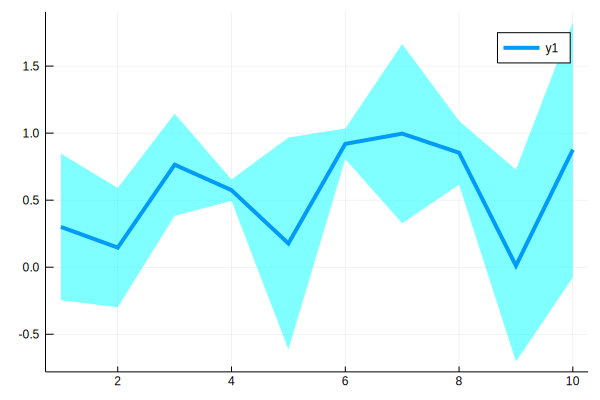

In [88]:
 plot(rand(10),ribbon=rand(10),fill=:cyan,linewidth=4)

In [89]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [90]:
x=3
println(f1(x))

18


$$\lambda + \beta$$
$$\frac{12}{4}$$

In [91]:
#old code


function grid_satisfactionOLD(start_grid) 
cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            cell_surrounding = []
            if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
                for ii in 0:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
                for ii in 0:1
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==1))#top left corner
                for ii in 1:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==GRID_SIZE))#top right corner
                for ii in 1:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==1))#bottom left corner
                for ii in 0:1
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
                for ii in 1:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
                for ii in 0:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
                for ii in 0:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
                for ii in 0:1
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
        end
    end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfactionOLD(start_grid)
println("random grid satisfactionOLD value=",satisfiedOneGrid)
R_MAX = grid_satisfactionOLD(set_grid)
println("set grid satisfactionOLD value=",R_MAX)

random grid satisfactionOLD value=91
set grid satisfactionOLD value=140


In [92]:

#=
moneyGrid2 = move_cells_for_wealth_NoDynamics(moneyGrid)

println("---")
println("number of empty resident cells=",length(findall(moneyGrid2[:,:,1] .== 0)))
println("nmber of empty finance cells=",length(findall(moneyGrid2[:,:,2] .== 0)))
println("sum of total finance on finance cells=",sum(moneyGrid2[:,:,2]) )  
println("grid the same as before for residential=",moneyGrid2[:,:,1] == moneyGrid[:,:,1])
println("grid the same as before for finance=",moneyGrid2[:,:,2] == moneyGrid[:,:,2])
println("financial grid deviation=",financial_grid_deviation(moneyGrid))
println("financial grid2 deviation=",financial_grid_deviation(moneyGrid2))
println("grid2 satisfaction=",grid_satisfaction(moneyGrid2[:,:,1]))
println("---")

wdevTmp = round(financial_grid_deviation(moneyGrid2),digits=2)    
Rtmp = grid_satisfaction(moneyGrid2[:,:,1])
hm = heatmap(moneyGrid2[:,:,2],title="cell wealth \n deviation=$(wdevTmp)",
showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
    framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
c=ColorGradient([:red,:white]))
hm2 = heatmap(moneyGrid2[:,:,1],title="cell identity label \n R=$(Rtmp)",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

p2=plot(hm,hm2)
display(p2)
#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
=#
